In [1]:
# Enable interactive figures in Jupyter Notebook
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import matplotlib.ticker as ticker

np.set_printoptions(suppress=True)


In [2]:
def create_rotation_matrix(yaw, pitch, roll):
    # Convert angles to radians
    yaw = np.radians(yaw)
    pitch = np.radians(pitch)
    roll = np.radians(roll)
    # Yaw matrix around Y axis
    R_yaw = np.array([
        [np.cos(yaw), 0, np.sin(yaw)],
        [0, 1, 0],
        [-np.sin(yaw), 0, np.cos(yaw)]
    ])
    # Pitch matrix around X axis
    R_pitch = np.array([
        [1, 0, 0],
        [0, np.cos(pitch), -np.sin(pitch)],
        [0, np.sin(pitch), np.cos(pitch)]
    ])
    # Roll matrix around Z axis
    R_roll = np.array([
        [np.cos(roll), -np.sin(roll), 0],
        [np.sin(roll), np.cos(roll), 0],
        [0, 0, 1]
    ])
    # Combine the matrices
    R_combined = R_roll.dot(R_pitch).dot(R_yaw)
    return R_combined

In [3]:
def createGTCameraParameters(focal_length_x, focal_length_y, principal_point_x, principal_point_y, R, camera_translation_vector_from_world_origin):
    # Construct a 4x4 extrinsic matrix
    extrinsic_matrix = np.eye(4)
    extrinsic_matrix[:3, :3] = R  # Rotation
    extrinsic_matrix[:3, 3] = -R @ camera_translation_vector_from_world_origin  # Translation
    
    # Construct the intrinsic matrix (3x4)
    K = np.array([[focal_length_x, 0, principal_point_x, 0],
                  [0, focal_length_y, principal_point_y, 0],
                  [0, 0, 1, 0]])
    
    # Camera projection matrix P = K * [R|t]
    P = np.dot(K, extrinsic_matrix)
    
    print("\nCamera Center in World Coordinates:")
    print(camera_translation_vector_from_world_origin)
    print("\nCamera Translation Vector (t):")
    print(extrinsic_matrix[:3, 3])
    print("\nCamera Rotation Matrix (R):")
    print(R)
    print("\nExtrinsic Matrix [R|t]:")
    print(extrinsic_matrix)
    print("\nIntrinsic Matrix (K):")
    print(K)
    print("\nCamera Projection Matrix (P):")
    print(P)

    return P, extrinsic_matrix, K

In [4]:
def project_world_to_camera(points_3d, P, image_width, image_height):
    # Convert 3D points to homogeneous coordinates
    points_3d_homogeneous = np.column_stack((points_3d, np.ones((points_3d.shape[0], 1))))
    # Project the points using P
    points_2d_homogeneous = np.dot(P, points_3d_homogeneous.T).T
    # Normalize homogeneous coordinates
    points_2d_normalized = points_2d_homogeneous[:, :2] / points_2d_homogeneous[:, 2:]
    # Check if points are within the image boundaries (not used for error computation)
    points_inside_frame = np.logical_and.reduce((
        points_2d_normalized[:, 0] >= 0,
        points_2d_normalized[:, 0] <= image_width,  # image width
        points_2d_normalized[:, 1] >= 0,
        points_2d_normalized[:, 1] <= image_height   # image height
    ))
    return points_2d_normalized, points_inside_frame

In [5]:
def plotWorldPoints(ax, points, rotation_matrix, camera_origin):
    num_points = len(points)
    # Pre-generate(fix) colors for consistency
    np.random.seed(0)
    colors = np.random.rand(num_points, 3)
    for i in range(num_points):
        ax.scatter(points[i, 0], points[i, 1], points[i, 2], c=[colors[i]], marker='o', s=50)
        ax.text(points[i, 0], points[i, 1], points[i, 2], f'{i+1}', color='black', fontsize=10)
    
    # Plot a red cross at the world origin
    ax.plot([0], [0], [0], marker='x', markersize=10, color='red')
    
    # Plot world coordinate axes
    world_axes_length = 1.0
    ax.plot([0, world_axes_length], [0, 0], [0, 0], color='green', label='World X')
    ax.plot([0, 0], [0, world_axes_length], [0, 0], color='orange', label='World Y')
    ax.plot([0, 0], [0, 0], [0, 3], color='purple', label='World Z')
    
    # Label the world axes
    ax.text(world_axes_length, 0, 0, 'X', color='green', fontsize=12)
    ax.text(0, world_axes_length, 0, 'Y', color='orange', fontsize=12)
    ax.text(0, 0, 3, 'Z', color='purple', fontsize=12)
    
    # Plot the camera origin and coordinate axes
    ax.plot([camera_origin[0]], [camera_origin[1]], [camera_origin[2]], marker='x', markersize=10, color='blue')
    camera_axes_length = 1.0
    camera_x_axis = rotation_matrix[:, 0] * camera_axes_length + camera_origin
    camera_y_axis = rotation_matrix[:, 1] * camera_axes_length + camera_origin
    camera_z_axis = rotation_matrix[:, 2] * 3 + camera_origin
    ax.plot([camera_origin[0], camera_x_axis[0]], [camera_origin[1], camera_x_axis[1]], [camera_origin[2], camera_x_axis[2]], color='blue', label='Camera X')
    ax.plot([camera_origin[0], camera_y_axis[0]], [camera_origin[1], camera_y_axis[1]], [camera_origin[2], camera_y_axis[2]], color='cyan', label='Camera Y')
    ax.plot([camera_origin[0], camera_z_axis[0]], [camera_origin[1], camera_z_axis[1]], [camera_origin[2], camera_z_axis[2]], color='magenta', label='Camera Z')
    ax.text(camera_x_axis[0], camera_x_axis[1], camera_x_axis[2], 'X', color='blue', fontsize=12)
    ax.text(camera_y_axis[0], camera_y_axis[1], camera_y_axis[2], 'Y', color='cyan', fontsize=12)
    ax.text(camera_z_axis[0], camera_z_axis[1], camera_z_axis[2], 'Z', color='magenta', fontsize=12)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='upper left')

    ax.grid(True)

In [6]:
def plotImagePixelPoints(ax, image_points, image_width=640, image_height=480):
    num_points = len(image_points)
    # Pre-generate(fix) colors for consistency
    np.random.seed(0)
    colors = np.random.rand(num_points, 3)
    # Invert y-coordinates for image coordinate system (origin at top-left)
    image_points[:, 1] = -image_points[:, 1]
    ax.plot([0], [0], marker='x', markersize=10, color='red')
    for i in range(num_points):
        ax.scatter(image_points[i, 0], image_points[i, 1], c=[colors[i]], marker='o', s=50)
        ax.text(image_points[i, 0], image_points[i, 1], f'{i+1}', color='black', fontsize=10)
    ax.set_xlabel('U (pixels)')
    ax.set_ylabel('V (pixels)')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{abs(x):0.0f}'))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{abs(y):0.0f}'))
    ax.set_xlim(0, image_width)
    ax.set_ylim(-image_height, 0)
    ax.grid(True)

### --------------------------
### Task-1 Implementation with Interactive 3D Plot
### --------------------------

In [7]:
# GT Intrinsic parameters (in pixels)
focal_length_x = 800.0 
focal_length_y = 700.0
principal_point_x = 320.0
principal_point_y = 240.0
image_width = 640
image_height = 480

# GT Extrinsic parameters (in degrees and meters)
camera_yaw = 3     # small rotation around Y axis
camera_pitch = 2   # small rotation around X axis
camera_roll = 5    # small rotation around Z axis

# Camera translation (in meters)
camera_translation_vector_from_world_origin = np.array([2, 2, 12], dtype=np.float32)

# Non-coplanar 3D points (provided)
world_3D_points = np.array([[1.0, 1.0, 1.0],
                            [1.0, 2.0, 2.0],
                            [1.0, 3.0, 3.0],
                            [2.0, 1.0, 4.0],
                            [2.0, 2.0, 5.0],
                            [2.0, 3.0, 6.0],
                            [2.0, 4.0, 2.5],
                            [2.5, 1.0, 8.0],
                            [2.5, 2.0, 9.0],
                            [2.5, 3.0, 5.5]], dtype=np.float32)


Camera Center in World Coordinates:
[ 2.  2. 12.]

Camera Translation Vector (t):
[ 1.53940331 -2.23576435 12.02628767]

Camera Rotation Matrix (R):
[[-0.99467026 -0.08885585  0.05230407]
 [-0.08710265  0.99558784  0.0348995 ]
 [-0.05517433  0.03015767 -0.9980212 ]]

Extrinsic Matrix [R|t]:
[[-0.99467026 -0.08885585  0.05230407  1.53940331]
 [-0.08710265  0.99558784  0.0348995  -2.23576435]
 [-0.05517433  0.03015767 -0.9980212  12.02628767]
 [ 0.          0.          0.          1.        ]]

Intrinsic Matrix (K):
[[800.   0. 320.   0.]
 [  0. 700. 240.   0.]
 [  0.   0.   1.   0.]]

Camera Projection Matrix (P):
[[-813.39199048  -61.43422386 -277.52352325 5079.93470764]
 [ -74.21369291  704.14933053 -215.0954395  1321.27399874]
 [  -0.05517433    0.03015767   -0.9980212    12.02628767]]


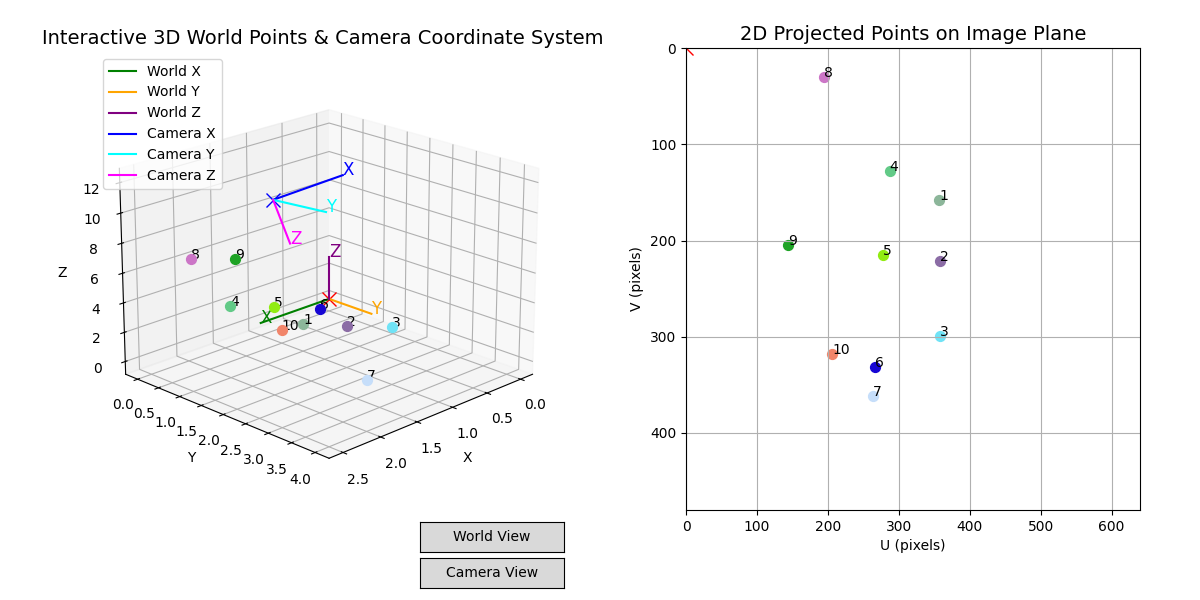

In [8]:
# Create camera rotation matrix from Euler angles
camera_rotation_matrix = create_rotation_matrix(camera_yaw, camera_pitch, camera_roll)
# Invert X and Z axes for the desired camera coordinate system
camera_rotation_matrix[:, 0] = -camera_rotation_matrix[:, 0]
camera_rotation_matrix[:, 2] = -camera_rotation_matrix[:, 2]
# For world-to-camera transformation, use the transpose
R = camera_rotation_matrix.T

# Generate the ground truth camera projection matrix and supporting matrices
P, RT, K = createGTCameraParameters(focal_length_x, focal_length_y, principal_point_x, principal_point_y, R, camera_translation_vector_from_world_origin)

# Project 3D world points to 2D image coordinates
camera_pixel_2D_points, insideViewOrNot = project_world_to_camera(world_3D_points, P, image_width, image_height)

# Create a figure with two side-by-side subplots
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

# Set initial view angles for the 3D plot
initial_elev = 20
initial_azim = 45
ax1.view_init(elev=initial_elev, azim=initial_azim)

# Plot the 3D world points and camera coordinate system
plotWorldPoints(ax1, world_3D_points, camera_rotation_matrix, camera_translation_vector_from_world_origin)
ax1.set_title('Interactive 3D World Points & Camera Coordinate System', fontsize=14)

# Plot the 2D projected image points
plotImagePixelPoints(ax2, camera_pixel_2D_points, image_width, image_height)

ax2.set_title('2D Projected Points on Image Plane', fontsize=14)

# Create an axis for each button in figure coordinates:
button_wv = fig.add_axes([0.35, 0.08, 0.12, 0.05])  # x-pos, y-pos, width, height
button_cv = fig.add_axes([0.35, 0.02, 0.12, 0.05])

world_view_button = Button(button_wv, 'World View')
camera_view_button = Button(button_cv, 'Camera View')

def reset_world_view(event):
    """Set the 3D view to 'world view' angles."""
    ax1.view_init(elev=20, azim=45)  # e.g. for "world view"
    plt.draw()

def reset_camera_view(event):
    """Set the 3D view to 'camera view' angles."""
    ax1.view_init(elev=90, azim=90)  # e.g. for "camera view"
    plt.draw()

world_view_button.on_clicked(reset_world_view)
camera_view_button.on_clicked(reset_camera_view)

# Manually adjust subplot layout instead of tight_layout
fig.subplots_adjust(left=0.08, right=0.95, top=0.92, bottom=0.15, wspace=0.3)
plt.show()